<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LayoutLM/Fine_tuning_LayoutLMForSequenceClassification_on_RVL_CDIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMForSequenceClassification` on the [RVL-CDIP dataset](https://www.cs.cmu.edu/~aharley/rvl-cdip/), which is a document image classification task. Each scanned document in the dataset belongs to one of 16 classes, such as "resume" or "invoice" (so it's a multiclass classification problem). The entire dataset consists of no less than 400,000 (!) scanned documents. 

For demonstration purposes, we are going to fine-tune the model on a really small subset (one example per class), and verify whether the model is able to overfit them. Note that LayoutLM achieves state-of-the-art results on RVL-CDIP, with a classification accuracy of 94.42% on the test set.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318
* LayoutLM docs in the Transformers library: https://huggingface.co/transformers/model_doc/layoutlm.html


## Setting up environment

First, we install the 🤗 transformers and datasets libraries, as well as the [Tesseract OCR engine](https://github.com/tesseract-ocr/tesseract) (built by Google). LayoutLM requires an external OCR engine of choice to turn a document into a list of words and bounding boxes.

In [2]:
!pip list | grep "datasets\|transformers"

datasets                1.11.0
transformers            4.9.0.dev0


In [3]:
#! pip install transformers datasets
!(pip list | grep "datasets") || pip install datasets
!(pip list | grep "transformers") || pip install transformers

datasets                1.11.0
transformers            4.9.0.dev0


In [4]:
# Depending on one's Linux distro, one need to activate
# one of the following lines to install Tesseract
!pacman -Qs tesseract || sudo pacman -S tesseract --noconfirm
#!sudo apt install tesseract-ocr

local/tesseract 4.1.1-7
    An OCR program
local/tesseract-data-eng 2:4.1.0-1 (tesseract-data)
    Tesseract OCR data (eng)


In [5]:
!(pip list | grep pytesser) || pip install pytesseract

pytesseract             0.3.8


## Getting the data

Next, we download a small subset of the RVL-CDIP dataset (which I prepared), containing 15 documents (one example per class)[ _**But you mentioned that there were 16 classes...**_  ]. I omitted the "handwritten" class, because the OCR results were mediocre. [ _**Oh, alright.**_ ]

In [7]:
from pathlib import Path
Path("RVL_CDIP_one_example_per_class").is_dir()

True

In [8]:
import requests, zipfile, io
from pathlib import Path

def download_data():
    url = "https://www.dropbox.com/s/kuw05qmc4uy474d/RVL_CDIP_one_example_per_class.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

path_dataset = Path("RVL_CDIP_one_example_per_class")
if not path_dataset.is_dir():
    download_data()

In [9]:
ls

Add_image_embeddings_to_LayoutLM.ipynb
Fine_tuning_LayoutLMForSequenceClassification_on_RVL_CDIP.ipynb
Fine_tuning_LayoutLMForSequenceClassification_on_RVL_CDIP_v01.ipynb
Fine_tuning_LayoutLMForTokenClassification_on_FUNSD.ipynb
RVL_CDIP_one_example_per_class/
trash.py


In [10]:
!tree RVL_CDIP_one_example_per_class/

RVL_CDIP_one_example_per_class/
├── advertisement
│   └── 0000121291.tif
├── budget
│   └── 00000337.tif
├── email
│   └── 0011834351.tif
├── file_folder
│   └── 0000319200.tif
├── form
│   └── 00043194.tif
├── invoice
│   └── 0000145869.tif
├── letter
│   └── 0000000700.tif
├── memo
│   └── 0000021894.tif
├── news_article
│   └── 0000009966.tif
├── presentation
│   └── 0000076169.tif
├── questionnaire
│   └── 0000002206.tif
├── resume
│   └── 0000157402.tif
├── scientific_publication
│   └── 00265263_00265269.tif
├── scientific_report
│   └── 00060713.tif
└── specification
    └── 0000011368.tif

15 directories, 15 files


Let's look at a random training example (in this case, a resume):

(Before conversion) image.mode = L


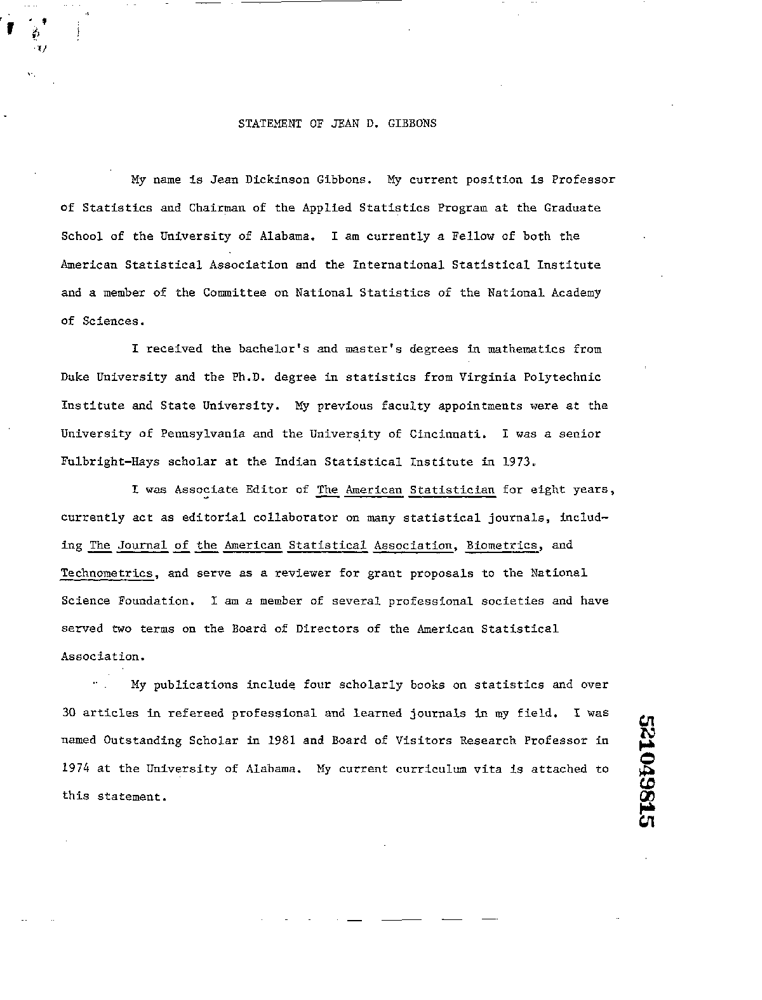

In [26]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(path_dataset / "resume/0000157402.tif")
print(f"(Before conversion) image.mode = {image.mode}")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [16]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,762,1000,-1,NaN
1,2,1,1,0,0,0,29,18,17,7,-1,NaN
2,3,1,1,1,0,0,29,18,17,7,-1,NaN
3,4,1,1,1,1,0,29,18,17,7,-1,NaN
4,5,1,1,1,1,1,29,18,17,7,11,<
...,...,...,...,...,...,...,...,...,...,...,...,...
266,5,1,5,1,1,2,98,793,68,8,74,statemeat.
267,2,1,6,0,0,0,639,715,16,112,-1,NaN
268,3,1,6,1,0,0,639,715,16,112,-1,NaN
269,4,1,6,1,1,0,639,715,16,112,-1,NaN


In [17]:
ocr_df = ocr_df.dropna().reset_index(drop=True)
ocr_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,29,18,17,7,11,<
1,5,1,2,1,1,1,38,45,8,7,56,v
2,5,1,3,1,1,1,239,119,63,9,87,STATEMENT
3,5,1,3,1,1,2,310,119,13,9,91,OF
4,5,1,3,1,1,3,331,119,28,9,90,JEAN
...,...,...,...,...,...,...,...,...,...,...,...,...
224,5,1,4,4,4,12,532,764,55,9,88,attached
225,5,1,4,4,4,13,596,766,12,7,89,to
226,5,1,5,1,1,1,63,790,26,10,89,this
227,5,1,5,1,1,2,98,793,68,8,74,statemeat.


In [18]:
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)  # fields consisting of entirely spaces
ocr_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,29,18,17,7,11,<
1,5,1,2,1,1,1,38,45,8,7,56,v
2,5,1,3,1,1,1,239,119,63,9,87,STATEMENT
3,5,1,3,1,1,2,310,119,13,9,91,OF
4,5,1,3,1,1,3,331,119,28,9,90,JEAN
...,...,...,...,...,...,...,...,...,...,...,...,...
224,5,1,4,4,4,12,532,764,55,9,88,attached
225,5,1,4,4,4,13,596,766,12,7,89,to
226,5,1,5,1,1,1,63,790,26,10,89,this
227,5,1,5,1,1,2,98,793,68,8,74,statemeat.


In [19]:
ocr_df.select_dtypes('float')

""
0
1
2
3
4
...
224
225
226
227


In [20]:
ocr_df.select_dtypes('float').columns

Index([], dtype='object')

In [21]:
str(np.nan)

'nan'

In [22]:
np.nan is np.nan

True

In [23]:
np.nan == np.nan

False

In [5]:
# ocr_df.text is just the column named text of ocr_df
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

"ot uv STATEMENT OF JEAN D, GIBBONS My name 4s Jean Dickinson Gibbons. My current position is Professor of Statistics and Chairman of the Applied Statistics Program at the Graduate School of the University of Alabana, I am currently a Fellow of both the American Statistical Association and the International Statistical Institute and a menber of the Committee on National Statistics of the National, Acadeny of Scdences. I received the bachelor's and master's degrees in mathematics from Duke University and the Ph.D. degree in statistics from Virginia Polytechnic Institute and State University. My previous faculty appointments were at the University of Pennsylvania and the University of Cincinnati. I was a senior Fulbright-Hays scholar at the Indian Statistical Institute in 1973. Twas Associate Editor of The Anertcan Statistician for eight years, currently act as editortal collaborator on many statistical journals, includ~ Technometrics, and serve as a reviewer for grant proposals to the N

The last word `stsepotzs` is probably Tesseract's answer for the vertical number `521049815` on the right.

We can also visualize the bounding boxes of the recognized words, as follows:

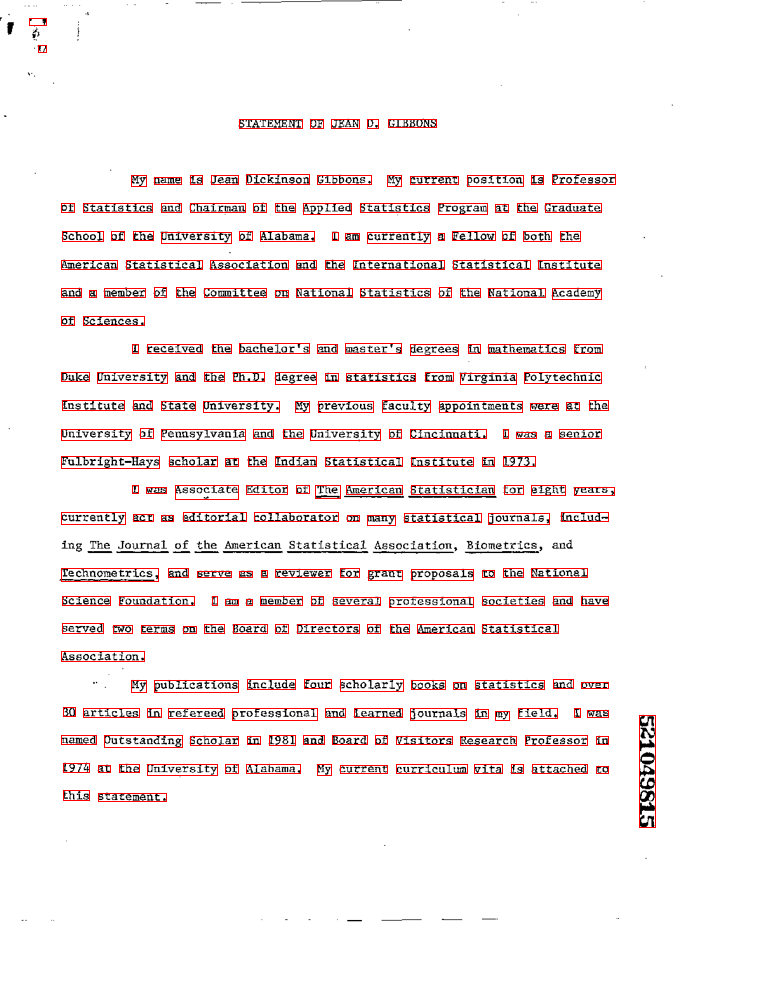

In [25]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    #x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    x, y, w, h = row  # no need of tuple()
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")  # not necessary to specify "RGB" again
for box in actual_boxes:
    draw.rectangle(box, outline='red')

image

## Preprocessing the data using 🤗 datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: `image_path` and `label`.

In [35]:
import pandas as pd
import os

#dataset_path = "/content/RVL_CDIP_one_example_per_class"
#labels = [label for label in os.listdir(dataset_path)]

labels = [subfolder.name for subfolder in path_dataset.iterdir()]
labels

['resume',
 'form',
 'advertisement',
 'presentation',
 'scientific_report',
 'scientific_publication',
 'budget',
 'memo',
 'questionnaire',
 'specification',
 'invoice',
 'letter',
 'news_article',
 'file_folder',
 'email']

In [37]:
#idx2label = {v: k for v, k in enumerate(labels)}
#label2idx = {k: v for v, k in enumerate(labels)}

idx2label = {}
label2idx = {}
for idx, label in enumerate(labels):
    idx2label[idx]  = label
    label2idx[label] = idx

label2idx

{'resume': 0,
 'form': 1,
 'advertisement': 2,
 'presentation': 3,
 'scientific_report': 4,
 'scientific_publication': 5,
 'budget': 6,
 'memo': 7,
 'questionnaire': 8,
 'specification': 9,
 'invoice': 10,
 'letter': 11,
 'news_article': 12,
 'file_folder': 13,
 'email': 14}

In [47]:
for tif in path_dataset.glob("*/*.tif"):
    print(tif)
    break

RVL_CDIP_one_example_per_class/resume/0000157402.tif


In [50]:
tif.parent.name

'resume'

In [51]:
image_paths = []
labels = []

for image_path in path_dataset.glob("*/*.tif"):
    label = image_path.parent.name
    image_paths.append(image_path)
    labels.append(label)

data = pd.DataFrame.from_dict({'image_path': image_paths, 'label': labels})
data.head()

,image_path,label
0,RVL_CDIP_one_example_per_class/resume/00001574...,resume
1,RVL_CDIP_one_example_per_class/form/00043194.tif,form
2,RVL_CDIP_one_example_per_class/advertisement/0...,advertisement
3,RVL_CDIP_one_example_per_class/presentation/00...,presentation
4,RVL_CDIP_one_example_per_class/scientific_repo...,scientific_report


In [52]:
len(data)

15

Now, let's apply OCR to get the words and bounding boxes of every image. To do this efficiently, we turn our Pandas dataframe into a HuggingFace `Dataset` object, and use the `.map()` functionality to get the words and normalized bounding boxes of every image. Note that this can take a while to run (Tesseract seems to be a bit slow).

**(?)** _normalized_ bbox?<br>
**(R)** Not for drawing, but for layoutLM.

It seems that the `datasets` package has difficulty handling `Path` object, let's convert them to strings.

In [57]:
data.dtypes

image_path    object
label         object
dtype: object

I am not sure if `transform()` is designed for this, but `map()` seems to be capable of this, so let's use `map()` for the moment.

In [60]:
data["image_path"] = data["image_path"].map(str)

0     RVL_CDIP_one_example_per_class/resume/00001574...
1      RVL_CDIP_one_example_per_class/form/00043194.tif
2     RVL_CDIP_one_example_per_class/advertisement/0...
3     RVL_CDIP_one_example_per_class/presentation/00...
4     RVL_CDIP_one_example_per_class/scientific_repo...
5     RVL_CDIP_one_example_per_class/scientific_publ...
6     RVL_CDIP_one_example_per_class/budget/00000337...
7     RVL_CDIP_one_example_per_class/memo/0000021894...
8     RVL_CDIP_one_example_per_class/questionnaire/0...
9     RVL_CDIP_one_example_per_class/specification/0...
10    RVL_CDIP_one_example_per_class/invoice/0000145...
11    RVL_CDIP_one_example_per_class/letter/00000007...
12    RVL_CDIP_one_example_per_class/news_article/00...
13    RVL_CDIP_one_example_per_class/file_folder/000...
14    RVL_CDIP_one_example_per_class/email/001183435...
Name: image_path, dtype: object

Error still persists. Let's try with the `astype()` method:

In [65]:
data["image_path"] = data["image_path"].astype("string")

In [68]:
import datasets
datasets.__version__, pd.__version__

('1.11.0', '1.3.1')

In [67]:
from datasets import Dataset
dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['image_path', 'label'],
    num_rows: 15
})

Great!

In [69]:
def normalize_box(box, width, height):
    # Recall the order: topleft_x, topleft_y, bottomright_x, bottomright_y
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

def apply_ocr(data_row):
    # get the image
    image = Image.open(data_row['image_path'])

    width, height = image.size
    
    # apply ocr to the image 
    ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
    float_cols = ocr_df.select_dtypes('float').columns
    ocr_df = ocr_df.dropna().reset_index(drop=True)
    ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
    ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
    ocr_df = ocr_df.dropna().reset_index(drop=True)

    # get the words and actual (unnormalized) bounding boxes
    #words = [word for word in ocr_df.text if str(word) != 'nan'])
    words = list(ocr_df.text)
    words = [str(w) for w in words]
    coordinates = ocr_df[['left', 'top', 'width', 'height']]
    actual_boxes = []
    for idx, row in coordinates.iterrows():
        x, y, w, h = row
        actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
        actual_boxes.append(actual_box)
    
    # normalize the bounding boxes
    boxes = []
    for box in actual_boxes:
        boxes.append(normalize_box(box, width, height))
    
    # add as extra columns 
    assert len(words) == len(boxes)
    data_row['words'] = words
    data_row['bbox'] = boxes
    return data_row

updated_dataset = dataset.map(apply_ocr)
updated_dataset

  0%|          | 0/15 [00:00<?, ?ex/s]

**(?)** In the `apply_ocr()` function, isn't the line
```python
ocr_df = ocr_df.dropna().reset_index(drop=True)
```
repetitive?

Think of `updated_dataset` (which actually is a `datasets.Dataset` object, but not too far from a `pd.DataFrame`) as the same dataframe as `data` augmented with two new colummns `words` and `bbox`

In [82]:
updated_dataset.to_pandas()

,image_path,label,words,bbox
0,RVL_CDIP_one_example_per_class/resume/00001574...,resume,"[<, v, STATEMENT, OF, JEAN, D,, GIZBONS, My, n...","[[38, 18, 60, 25], [49, 45, 60, 52], [313, 119..."
1,RVL_CDIP_one_example_per_class/form/00043194.tif,form,"[CLINICAL, RECORD, Do, nony, __Page, 1§, =, 2....","[[139, 98, 208, 109], [218, 97, 279, 109], [72..."
2,RVL_CDIP_one_example_per_class/advertisement/0...,advertisement,"[[, P87~, 57, %, MAY, (987, ~, OCT., 19S7, ‘On...","[[51, 9, 90, 36], [381, 13, 494, 37], [503, 11..."
3,RVL_CDIP_one_example_per_class/presentation/00...,presentation,"[SUPERIOR, PRODUCT, QUALITY, CPC, PRESENTATION...","[[374, 243, 466, 256], [481, 243, 560, 256], [..."
4,RVL_CDIP_one_example_per_class/scientific_repo...,scientific_report,"[sy, w., orpPEL, XA,, FALS., ANALYSIS, NO., 34...","[[108, 60, 148, 67], [154, 60, 167, 66], [173,..."
5,RVL_CDIP_one_example_per_class/scientific_publ...,scientific_publication,"[4, Carcinogenesis, Assay, of, Subfractions, o...","[[32, 1, 96, 17], [441, 133, 581, 146], [602, ..."
6,RVL_CDIP_one_example_per_class/budget/00000337...,budget,"[THE, TOBACCO, INSTITUTE, CHECK, REQUEST, VEND...","[[383, 90, 428, 103], [436, 90, 549, 103], [55..."
7,RVL_CDIP_one_example_per_class/memo/0000021894...,memo,"[TR,, R, B, GRIPFITH, (3), De., R., R,, Jobase...","[[153, 56, 177, 66], [187, 57, 203, 65], [213,..."
8,RVL_CDIP_one_example_per_class/questionnaire/0...,questionnaire,"[cory_, 1L, MORE, EFFECTIVE, ADVERTISING/MERCH...","[[322, 310, 381, 328], [410, 308, 416, 327], [..."
9,RVL_CDIP_one_example_per_class/specification/0...,specification,"[Material, Number,, 13-002, (, MATERIAL, SPECI...","[[608, 36, 704, 50], [717, 35, 788, 49], [838,..."


Next, we can turn the word-level `'words'` and `'bbox'` columns into token-level `input_ids`, `attention_mask`, `bbox` and `token_type_ids` using `LayoutLMTokenizer`.

In [81]:
from transformers import LayoutLMTokenizer
import torch

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

2021-08-05 12:39:27.891154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-05 12:39:27.891192: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Play with the `tokenize()` method of a `LayoutLMTokenizer` instance.

In [87]:
tokenizer.tokenize("CLINICAL"), tokenizer.tokenize("Carcinogenesis"), \
tokenizer.tokenize("ADVERTISING/MERCHANT")

(['clinical'],
 ['car', '##cino', '##genesis'],
 ['advertising', '/', 'merchant'])

In [88]:
tokenizer.tokenize("It is a sunny day.")

['it', 'is', 'a', 'sunny', 'day', '.']

For more info on `LayoutLMTokenizer` and on `LayoutLMModel`, one may refer to `./LayoutLMModel_example.ipynb` in this same directory.

In [99]:
def encode(data_row, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
    words = data_row['words']
    normalized_word_boxes = data_row['bbox']

    assert len(words) == len(normalized_word_boxes)
    # Already done in apply_ocr(). Here as a check for new inference images?

    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))
        # we repeat the same box info for subwords; all subwords of the same word share the same box info.
    
    # Truncation of token_boxes
    special_tokens_count = 2  # <cls> and <sep>, probably
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
    
    # add bounding boxes of cls + sep tokens (in the beginning and at the end)
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    # So at this point token_boxes will always be of length AT MOST max_seq_length
    # padded with <cls> and <sep> tokens (in the beginning and at the end)
    
    encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
    # encoding is a dictionary of keys like: 'input_ids', 'token_type_ids', 'attention_mask'

    # Padding of token_boxes up the bounding boxes to the sequence length.
    input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
    padding_length = max_seq_length - len(input_ids)
    #token_boxes += [pad_token_box] * padding_length
    token_boxes.extend([pad_token_box] * padding_length)
    encoding['bbox'] = token_boxes
    # N.B. by this point, encoding['bbox'] is of length 512 FOR SURE,
    #      not AT MOST 512 any more.
    encoding['label'] = label2idx[data_row['label']]

    assert len(encoding['input_ids']) == max_seq_length
    assert len(encoding['attention_mask']) == max_seq_length
    assert len(encoding['token_type_ids']) == max_seq_length
    assert len(encoding['bbox']) == max_seq_length

    return encoding

In [100]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D

# we need to define the features ourselves 
# as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

# Because the function encode() has other args, we need to
# wrap it up with lambda here to make it a sinlge-arg function
encoded_dataset = updated_dataset.map(
    lambda row: encode(row), 
    features=features,
)

  0%|          | 0/15 [00:00<?, ?ex/s]

In [101]:
encoded_dataset

Dataset({
    features: ['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label', 'image_path', 'words'],
    num_rows: 15
})

Finally, we set the format to PyTorch, as the LayoutLM implementation in the Transformers library is in PyTorch. We also specify which columns we are going to use. (We drop out the two columns `"image_path"` and `"words"`)

In [103]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [105]:
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
batch = next(iter(dataloader))
type(batch)

dict

In [106]:
batch.keys()

dict_keys(['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [111]:
batch["input_ids"].shape

torch.Size([1, 512])

Let's verify whether the input ids are created correctly by decoding them back to text:

In [15]:
tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] tr, rh, griffith ( ) de. re 2. jobaisen / oja 8 february 1963, chromatography of arona concentrates 38 oer continuing : investigations on the separation of tobacco acum con = sgakeace constituents ws have found that columa clioaatograply of evade aren see pence on ilies gol ie excellene tor their initial fractlostions tate ‘ hee becona the basis for an improved isolation schema for cossovod a experinental suey of 23 - 70 mash silica gel iu hexane is added to a 1 em coluen untid sre atticn sol bed depth 1s 39 eu. a 2. 0 ¢ gample af a erude hgh eeopecacuee seagjcekemerate 48 then applied eo the top of the coluan in hexane, eluring je rsefemplisted ftree with hexane, and then with solvents of gradwally increasing poreritys, rections of 100 mi are collegtad and tho weights of eluted arenes of the flaereceat soven : renoval at 20° / 10 axe mesules fron the chrouatastapiy 7 of the flue - eured sud burley aruna concentrates are tabulated belove burley fluo - cured ee reaction ¢ solvent

In [16]:
idx2label[batch['label'][0].item()]

'memo'

In [116]:
batch['label']

tensor([5])

In [118]:
help(batch['label'][0].item)

Help on built-in function item:

item(...) method of torch.Tensor instance
    item() -> number
    
    Returns the value of this tensor as a standard Python number. This only works
    for tensors with one element. For other cases, see :meth:`~Tensor.tolist`.
    
    This operation is not differentiable.
    
    Example::
    
        >>> x = torch.tensor([1.0])
        >>> x.item()
        1.0



## Define the model

Here we define the model, namely `LayoutLMForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU (if there is GPU).



In [119]:
from transformers import LayoutLMForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
      

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler. Cf. [here](https://github.com/microsoft/unilm/blob/5d16c846bec56b6e88ec7de4fc3ceb7c803571a4/layoutlm/examples/classification/run_classification.py#L94) for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [18]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 30
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in dataloader:
      input_ids = batch["input_ids"].to(device)
      bbox = batch["bbox"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
      labels = batch["label"].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == labels).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0
Loss: 43.12694573402405
Training accuracy: 0.0
Epoch: 1
Loss: 35.339784145355225
Training accuracy: 33.333335876464844
Epoch: 2
Loss: 30.55066680908203
Training accuracy: 86.66667175292969
Epoch: 3
Loss: 27.842902660369873
Training accuracy: 86.66667175292969
Epoch: 4
Loss: 21.45477443933487
Training accuracy: 100.00000762939453
Epoch: 5
Loss: 19.765377640724182
Training accuracy: 93.33333587646484
Epoch: 6
Loss: 16.269045293331146
Training accuracy: 93.33333587646484
Epoch: 7
Loss: 13.61208951473236
Training accuracy: 100.00000762939453
Epoch: 8
Loss: 12.580875396728516
Training accuracy: 100.00000762939453
Epoch: 9
Loss: 9.917366653680801
Training accuracy: 100.00000762939453
Epoch: 10
Loss: 8.083266794681549
Training accuracy: 100.00000762939453
Epoch: 11
Loss: 8.36630928516388
Training accuracy: 93.33333587646484
Epoch: 12
Loss: 7.368062764406204
Training accuracy: 93.33333587646484
Epoch: 13
Loss: 5.720428228378296
Training accuracy: 100.00000762939453
Epoch: 14
Loss: 4.6

In [137]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 30
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
    print("Epoch:", epoch)
    running_loss = 0.0
    correct = 0
    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        bbox = batch["bbox"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["label"].to(device)

        # forward pass
        outputs = model(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels,
        )
        loss = outputs.loss

        running_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        correct += (predictions == labels).float().sum()

        # backward pass to get the gradients 
        loss.backward()

        # update
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
    
    print("Loss:", running_loss / batch["input_ids"].shape[0])
    accuracy = 100 * correct / len(data)
    print("Training accuracy:", accuracy.item())

Epoch: 0


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 42.85848617553711
Training accuracy: 0.0
Epoch: 1


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 35.35514736175537
Training accuracy: 26.66666603088379
Epoch: 2


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 31.085582971572876
Training accuracy: 60.0
Epoch: 3


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 26.01819610595703
Training accuracy: 86.66666412353516
Epoch: 4


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 21.268070578575134
Training accuracy: 100.0
Epoch: 5


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 17.821519672870636
Training accuracy: 100.0
Epoch: 6


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 14.944324970245361
Training accuracy: 100.0
Epoch: 7


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 12.004090905189514
Training accuracy: 100.0
Epoch: 8


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 10.480315148830414
Training accuracy: 100.0
Epoch: 9


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 9.997830599546432
Training accuracy: 100.0
Epoch: 10


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 6.795561790466309
Training accuracy: 100.0
Epoch: 11


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 5.5872146636247635
Training accuracy: 100.0
Epoch: 12


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 4.555944159626961
Training accuracy: 100.0
Epoch: 13


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 3.9307816475629807
Training accuracy: 100.0
Epoch: 14


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 3.747180223464966
Training accuracy: 100.0
Epoch: 15


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 3.3854708075523376
Training accuracy: 100.0
Epoch: 16


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 2.7858435213565826
Training accuracy: 100.0
Epoch: 17


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 2.537598744034767
Training accuracy: 100.0
Epoch: 18


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 2.3162263855338097
Training accuracy: 100.0
Epoch: 19


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 2.243908293545246
Training accuracy: 100.0
Epoch: 20


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.782788224518299
Training accuracy: 100.0
Epoch: 21


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.7411263957619667
Training accuracy: 100.0
Epoch: 22


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.4897607117891312
Training accuracy: 100.0
Epoch: 23


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.3779938146471977
Training accuracy: 100.0
Epoch: 24


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.253512866795063
Training accuracy: 100.0
Epoch: 25


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.2836721912026405
Training accuracy: 100.0
Epoch: 26


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.2144626528024673
Training accuracy: 100.0
Epoch: 27


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.1230122819542885
Training accuracy: 100.0
Epoch: 28


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 1.129708956927061
Training accuracy: 100.0
Epoch: 29


  0%|          | 0/15 [00:00<?, ?it/s]

Loss: 0.9561476483941078
Training accuracy: 100.0


## Test Code for Newbies of PyTorch
Including myself :D

In [122]:
len(list(model.parameters()))

205

In [123]:
next(model.parameters())

Parameter containing:
tensor([[-0.0111, -0.0777,  0.0293,  ..., -0.0323, -0.0190,  0.0403],
        [-0.0579, -0.0331, -0.0399,  ..., -0.0248, -0.0278, -0.0398],
        [-0.0261, -0.0383, -0.0225,  ...,  0.0011, -0.0803, -0.0019],
        ...,
        [-0.0186, -0.0593, -0.0167,  ..., -0.0243, -0.0096,  0.0050],
        [-0.0555, -0.0274,  0.0049,  ..., -0.0206, -0.0172, -0.0241],
        [-0.0328, -0.0788, -0.0211,  ..., -0.0187, -0.0497,  0.0444]],
       requires_grad=True)

In [125]:
type(next(model.parameters()))

torch.nn.parameter.Parameter

In [129]:
next(model.parameters()).names

(None, None)

In [130]:
len(dataloader)

15

In [132]:
!ls RVL_CDIP_one_example_per_class | wc -l

15


**(?)** Why `argmax(-1)`?
```python
predictions = outputs.logits.argmax(-1)
```

In [135]:
len(data)

15

## Legacy

The code below was used during the creation of this notebook, but is now not used anymore.